#    Titanic Supervised Learning Flow Project

![alt text](The-Titanic-Exterior.jpg)

In [1]:
#############IMPORTS#########

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import confusion_matrix,accuracy_score



In [3]:
#reading csv files
train_set = pd.read_csv('titanic_train.csv')
test_set = pd.read_csv('titanic_test.csv')

In [4]:
#showing top 5 rows of the dataset
print('Head of train set:')
print(train_set.head())
print('Head of test set:')
print(test_set.head())      


Head of train set:
   Pclass  Sex   Age  SibSp  Parch     Fare  Embarked  Survived
0       1    0  54.0      1      0  78.2667         1         1
1       2    0  45.0      0      0  13.5000         0         1
2       3    1  20.0      0      0   9.5000         0         0
3       3    1  36.0      0      0   7.8958         0         0
4       3    1  22.0      0      0   8.0500         0         0
Head of test set:
   Pclass  Sex        Age  SibSp  Parch     Fare  Embarked  Survived
0       3    1  35.000000      0      0   7.0500         0         0
1       3    1  30.000000      0      0   7.2500         0         0
2       3    1  29.699118      0      0  14.5000         0         0
3       3    0  21.000000      0      0   7.7500         2         0
4       3    1  32.000000      0      0  56.4958         0         1


In [5]:
#missing values
missing_vals = train_set.isnull().sum()
print("Missing values amount:")
print(missing_vals)

Missing values amount:
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
Survived    0
dtype: int64


In [6]:
#getting dublicated values
dup_rows = train_set[train_set.duplicated()]
amount_dup = dup_rows.shape[0]
print("amount of duplicated rows:")
print(amount_dup)
print(dup_rows)

amount of duplicated rows:
80
     Pclass  Sex        Age  SibSp  Parch     Fare  Embarked  Survived
46        3    1  29.699118      0      0   7.2500         0         0
74        3    0  29.699118      3      1  25.4667         0         0
94        3    0  29.699118      0      0   7.7500         2         1
142       2    1  34.000000      0      0  13.0000         0         0
150       3    1  20.000000      0      0   7.8542         0         0
..      ...  ...        ...    ...    ...      ...       ...       ...
697       3    1  25.000000      0      0   7.0500         0         0
700       3    0  29.699118      0      0   7.7500         2         1
704       2    1  23.000000      0      0  13.0000         0         0
706       3    1  29.699118      0      0   7.8958         0         0
710       2    1  29.699118      0      0   0.0000         0         0

[80 rows x 8 columns]


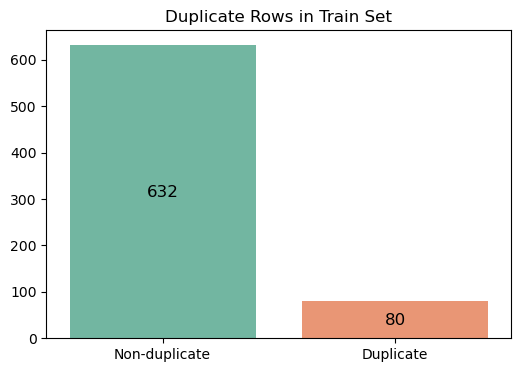

In [7]:
#we are counting the amount of dup rows
dup_rows = train_set[train_set.duplicated()]
dup_count = dup_rows.shape[0]

plt.figure(figsize=(6, 4))
ax = sns.barplot(x=['Non-duplicate', 'Duplicate'], y=[train_set.shape[0] - dup_count, dup_count], palette='Set2')
#showing the amount on bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height() / 2),
                ha='center', va='top', fontsize=12, color='black',xytext=(0,5),textcoords='offset points')

plt.title("Duplicate Rows in Train Set")
plt.show()

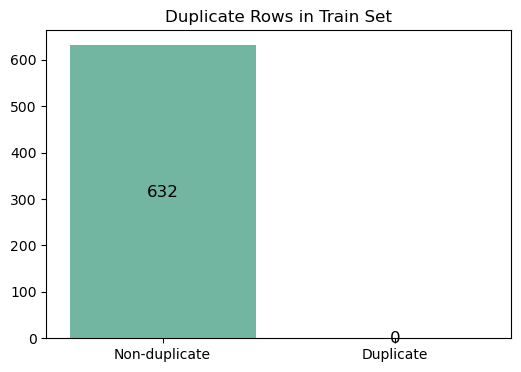

In [8]:
#now dropping the duplicated rows
train_set = train_set.drop_duplicates()

dup_rows = train_set[train_set.duplicated()]
dup_count = dup_rows.shape[0]

plt.figure(figsize=(6, 4))
ax = sns.barplot(x=['Non-duplicate', 'Duplicate'], y=[train_set.shape[0] - dup_count, dup_count], palette='Set2')

#showing the amount on bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height() / 2),
                ha='center', va='top', fontsize=12, color='black',xytext=(0,5),textcoords='offset points')

plt.title("Duplicate Rows in Train Set")
plt.show()

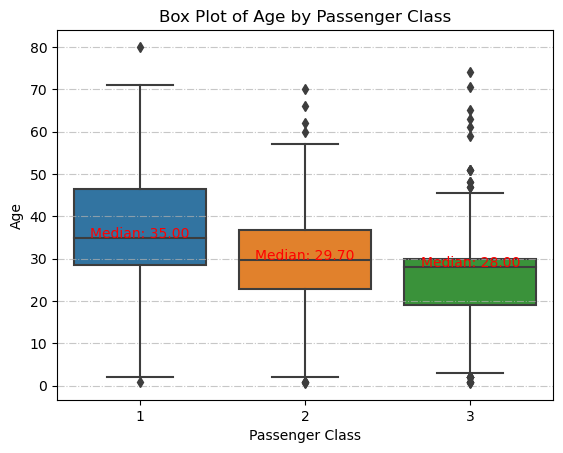

In [9]:
#outliers
# removing the outliers of age grouping by passenger class
# wealthier, older passengers may be more likely to travel in higher classes
# poorer, younger passengers might travel in lower classes
# so its often times a logical approach
sns.boxplot(
    x='Pclass',
    y='Age',  
    data=train_set
)

#grouping age column by the pclass column
medians = train_set.groupby('Pclass')['Age'].median()


for i, median in enumerate(medians):
    plt.text(i, median, f'Median: {median:.2f}', ha='center', c = 'r')

plt.title('Box Plot of Age by Passenger Class')
plt.xlabel("Passenger Class")
plt.ylabel('Age')
plt.grid(axis='y', linestyle='-.', alpha=0.7)  # Add a faint grid for readability

plt.show()

In [10]:
def remove_outliers_by_class(df, column, group_col, multiplier=1.5):
    
    for group in df[group_col].unique():
        group_data = df[df[group_col] == group]
        Q1 = group_data[column].quantile(0.25)
        Q3 = group_data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR
        df = df[~((df[group_col] == group) & ((df[column] < lower_bound) | (df[column] > upper_bound)))]

    return df


In [11]:
#removing the outliers of age grouping by passenger class

print(f"Number of rows before removing outliers: {train_set.shape[0]}")              
train_set = remove_outliers_by_class(train_set,'Age','Pclass')#function usage
print(f"Number of rows after removing outliers: {train_set.shape[0]}")              

Number of rows before removing outliers: 632
Number of rows after removing outliers: 597


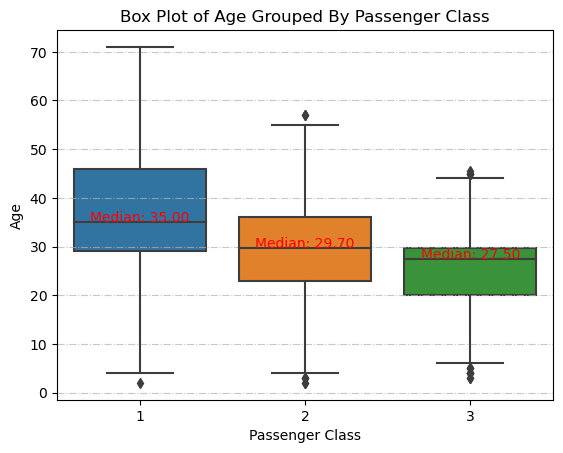

In [12]:
#checking new graph after removing the outliers

sns.boxplot(
    x='Pclass',
    y='Age',  
    data=train_set
)


medians = train_set.groupby('Pclass')['Age'].median()


for i, median in enumerate(medians):
    plt.text(i, median, f'Median: {median:.2f}', ha='center', c = 'r')

plt.title('Box Plot of Age Grouped By Passenger Class')
plt.xlabel("Passenger Class")
plt.ylabel('Age')
plt.grid(axis='y', linestyle='-.', alpha=0.7)  # Add a faint grid for readability

plt.show()

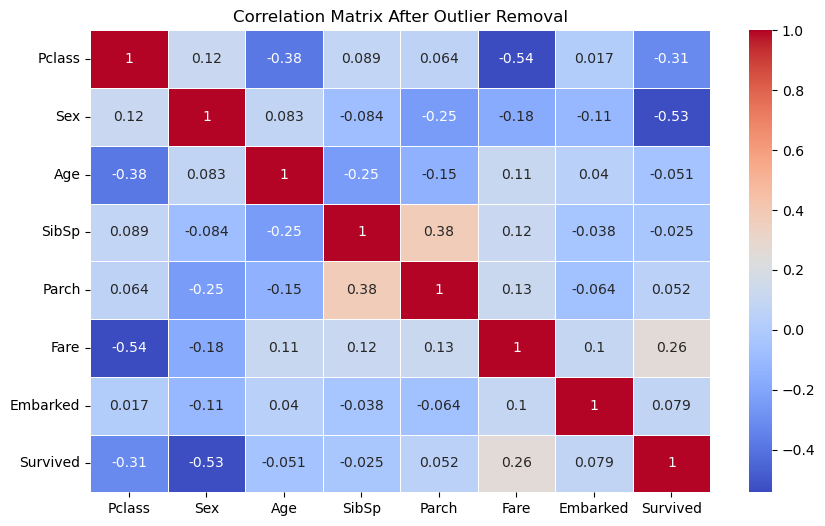

In [13]:
# correlation matrix heatmap graph of the data set
plt.figure(figsize=(10, 6))
sns.heatmap(train_set.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix After Outlier Removal")
plt.show()

 - Experiments


In [14]:
# First of all, this is the target label

X = train_set.drop('Survived', axis=1)
y = train_set['Survived']

numerical_features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'] # they are numbers
categorical_features = ['Sex', 'Embarked'] # they are binary, 0 male 1 female for example


In [15]:
# Fix missing values and scaling them

# scale using StandardScaler because its a numeric value
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
# scale using onehotencoder
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [16]:
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])


In [ ]:
# Defining the classifiers and hyperparameters
param_grid = {
    'classifier': [LogisticRegression(), RandomForestClassifier()],
    'classifier__C': [0.1, 1, 10],  # applies to LogisticRegression
    'classifier__n_estimators': [50, 100, 200]  # applies to RandomForestClassifier
}

pipe = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', LogisticRegression())])

param_grid = [
    {
        'classifier': [LogisticRegression()],
        'classifier__C': [0.1, 1, 10],
        'classifier__penalty': ['l2'],
        'classifier__solver': ['lbfgs'],
    },
    {
        'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [5, 10, 20],
    }
]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(f1_score, average='macro')

grid_search = GridSearchCV(pipe, param_grid, cv=skf, scoring=scorer, return_train_score=True)


# and  fitting the grid
grid_search.fit(X, y)


In [18]:
# Check the results
results = pd.DataFrame(grid_search.cv_results_)

print("Best parameters found: ", grid_search.best_params_)
print("Best macro F1 score: ", grid_search.best_score_)

display(results[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']])

Best parameters found:  {'classifier': RandomForestClassifier(max_depth=5, n_estimators=200), 'classifier__max_depth': 5, 'classifier__n_estimators': 200}
Best macro F1 score:  0.7859015192739234


,params,mean_test_score,std_test_score,rank_test_score
0,"{'classifier': LogisticRegression(), 'classifi...",0.777745,0.029723,4
1,"{'classifier': LogisticRegression(), 'classifi...",0.776698,0.032432,5
2,"{'classifier': LogisticRegression(), 'classifi...",0.778638,0.028599,3
3,{'classifier': RandomForestClassifier(max_dept...,0.773753,0.027308,7
4,{'classifier': RandomForestClassifier(max_dept...,0.780394,0.026120,2
5,{'classifier': RandomForestClassifier(max_dept...,0.785902,0.037148,1
6,{'classifier': RandomForestClassifier(max_dept...,0.768001,0.039234,9
7,{'classifier': RandomForestClassifier(max_dept...,0.774188,0.027859,6
8,{'classifier': RandomForestClassifier(max_dept...,0.768458,0.035405,8
9,{'classifier': RandomForestClassifier(max_dept...,0.744455,0.027771,10


 - Training 


In [19]:
# Use the best parameters found by GridSearchCV
best_params = grid_search.best_params_

# If the best classifier is RandomForestClassifier, extract the relevant parameters dynamically
if isinstance(grid_search.best_estimator_.named_steps['classifier'], RandomForestClassifier):
    best_model = RandomForestClassifier(
        max_depth=best_params['classifier__max_depth'],
        n_estimators=best_params['classifier__n_estimators'],
        random_state=42
    )
else:
    # If it's not RandomForestClassifier, use LogisticRegression 
    best_model = LogisticRegression(
        C=best_params['classifier__C'],
        solver='lbfgs',  # or dynamically from best_params if included
        random_state=42
    )

# Re train the test dataset (Ex4)
best_model.fit(X, y)

# Make predictions on the training set
y_train_pred = best_model.predict(X)

# Calculate the F1 score on the training set (macro average)
train_f1_score = f1_score(y, y_train_pred, average='macro')

# Calculate the accuracy on the training set
train_accuracy = accuracy_score(y, y_train_pred)

# Output the results
print(f"F1 score on the training set: {train_f1_score:.4f}")
print(f"Accuracy on the training set: {train_accuracy:.4f}")

F1 score on the training set: 0.8199
Accuracy on the training set: 0.8291


- Apply on test and show model performance 

In [20]:
# Fit the best model on the test data

X = test_set.drop('Survived', axis=1)
y = test_set['Survived']

best_model.fit(X, y)

# Make predictions on the training set
y_train_pred = best_model.predict(X)

# Calculate the F1 score and accuracy on the training set
train_f1_score = f1_score(y, y_train_pred, average='macro')
train_accuracy = accuracy_score(y, y_train_pred)

# Output the performance metrics
print(f"F1 score on the training set: {train_f1_score:.4f}")
print(f"Accuracy on the training set: {train_accuracy:.4f}")

# Create a DataFrame to compare actual and predicted labels
comparison_df = pd.DataFrame({
    'Actual': y,
    'Predicted': y_train_pred
})

# Display the first few rows to compare actual vs predicted labels
print("\nFirst 5 comparisons between actual and predicted labels:")
print(comparison_df.head())

# Optionally, display where predictions were incorrect
incorrect_predictions = comparison_df[comparison_df['Actual'] != comparison_df['Predicted']]
print(f"\nNumber of incorrect predictions: {len(incorrect_predictions)}")
print("\nFirst 5 examples of incorrect predictions:")
print(incorrect_predictions.head())


F1 score on the training set: 0.9213
Accuracy on the training set: 0.9330

First 5 comparisons between actual and predicted labels:
   Actual  Predicted
0       0          0
1       0          0
2       0          0
3       0          0
4       1          0

Number of incorrect predictions: 12

First 5 examples of incorrect predictions:
    Actual  Predicted
4        1          0
20       1          0
22       1          0
40       1          0
41       1          0


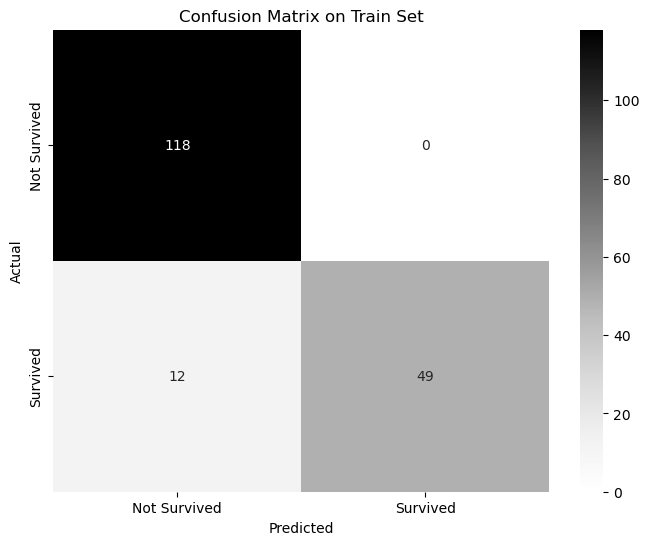

In [21]:
# Confusing matrix of the final result on the train set using the best hyperparams we found earlier

conf_matrix = confusion_matrix(y, y_train_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greys', xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])

plt.title('Confusion Matrix on Train Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

 #    **The End!**
![idan and Nick](THE_END.jpg)
